## Figures for Network model of Latent Recurrent Discharge (LRD)


### Some imports and settings


In [2]:
%load_ext autoreload
%autoreload 2
import ipywidgets
import warnings
from IPython.display import display, clear_output
import brian2.numpy_ as np
import matplotlib.pyplot as plt

from settings import COLOR, G_GABA_LIST, TAU_KCC2_LIST, text, logging

# start from defaults before loading stylesheet
plt.style.use("default")
plt.style.use("style/article.mplstyle")

# suppress warnings
np.seterr(all="ignore")
warnings.filterwarnings("ignore")

logger = logging.getLogger("lrd")

SAVE_FIGS = False
save_args = {}
interact_manual = ipywidgets.interact_manual.options(manual_name="Run")

def set_save_figs(save_figures=SAVE_FIGS, use_args=False, close=False, file_formats=["svg", "jpg"]):
    global SAVE_FIGS
    SAVE_FIGS = save_figures
    save_args["use_args"] = use_args
    save_args["close"] = close
    save_args["file_formats"] = file_formats

ipywidgets.interact(set_save_figs, file_formats=ipywidgets.SelectMultiple(options=["svg", "jpg", "png", "pdf"], value=["svg", "jpg"], rows=4, description="File formats",));


interactive(children=(Checkbox(value=False, description='save_figures'), Checkbox(value=False, description='us…

# Explainatory figure - Figure 2B,C and supplementary

Step up EGABA constantly every $x$ (e.g. 40) seconds, and plot the resulting firing rate of the network.

Note: In figure 2 fo the paper, only a portion is shown. The extra panels relate to the supplementary figures and look at conductances and vesicle availability + utilisation.

Warning: This widget thus also the specification of the number of neurons but that this slows things down dramatically)


In [5]:
from scripts.lrdfigure_explain import Explain
from widgets import new_explain_widget

def run_explain(
    N=1000,
    mv_step=4,
    time_per_value=40,
    egaba_start=-78,
    egaba_end=-34,
    seed="1337",
    plot_igaba=False,
    plot_mean_rate=True,
):
    import shutil

    np.random.seed(int(seed))

    __device_directory = f".cpp_{hash(str(locals()))}"
    prev_log_level = logging.getLogger("root").getEffectiveLevel()

    explain = Explain()
    explain.setup(__device_directory=__device_directory)
    explain.run(
        N=N,
        mv_step=mv_step,
        time_per_value=time_per_value,
        egaba=[egaba_start, egaba_end],
    )
    plot_rates = ("r_all", "r_I", "r_E") if plot_mean_rate else ("r_I", "r_E")
    explain.plot(plot_igaba=plot_igaba, plot_rates=plot_rates)
    if SAVE_FIGS:
        explain.save_figure(**save_args)
    # remove __device_directory used by brian sim
    shutil.rmtree(__device_directory, ignore_errors=True)
    logging.getLogger("root").setLevel(prev_log_level)
    return explain


new_explain_widget(run_explain)

interactive(children=(IntSlider(value=4, description='mV step', max=8, min=1), IntSlider(value=40, description…

# Alter conductances - Figure 2D+

1. Emulate picrotoxin (pink) by **reducing** $g_{GABA_{max}}$.
2. Emulate benzodiazepines (green) by **increasing** $g_{GABA_{max}}$.

We can see the effect of benzodiazepines depends on $E_{GABA}$.


In [34]:
from scripts.lrdfigure_drugs import Drugs
from widgets import new_drugs_widget


def run_drugs(benzo_strengths, egabas, picro_to_plot, benzo_to_plot):
    drugs = Drugs(benzo_strengths=benzo_strengths, egabas=egabas)
    drugs.run()
    drugs.plot(drugs_to_plot=(picro_to_plot, benzo_to_plot))
    if SAVE_FIGS:
        drugs.save_figure(**save_args)
    plt.show()
    return drugs


new_drugs_widget(run_drugs)

interactive(children=(VBox(children=(HBox(children=(SelectMultiple(description='Benzo strengths', index=(0, 1,…

## Start having dynamic chloride $Cl^-$

We compared networks with either hyperpolarised ($\approx E_{GABA} = -74 mV$) or depolarised ($ \approx E\_{GABA} = -46 mV$) EGABA.

The starting $E_{GABA}$ seems to have neglible, if any effect.

We further consider the effect of GABA conductance $g_{GABA_{max}}$ (brightness, rows) along with different $\tau_{KCC2}$ values (hue, traces).


In [62]:
from scripts.lrdfigure_chloride import Chloride
from widgets import new_chloride_widget


def run_chloride(
    tau_KCC2s,
    E_Cl_0s,
    g_GABAs,
    seeds,
    duration,
    burst_window,
    default_tau,
    stripplot_alpha,
    stripplot_size,
    stripplot_jitter,
):
    cl = Chloride(
        tau_KCC2s=tau_KCC2s,
        E_Cl_0s=E_Cl_0s,
        g_GABAs=g_GABAs,
        seeds=seeds,
    )
    cl.run(duration=duration).process(burst_window=burst_window)
    cl.plot(
        default_tau=default_tau,
        stripplot_alpha=stripplot_alpha,
        stripplot_size=stripplot_size,
        stripplot_jitter=stripplot_jitter,
    )
    if SAVE_FIGS:
        cl.save_figure(**save_args)
    return cl


new_chloride_widget(run_chloride)

interactive(children=(VBox(children=(VBox(children=(VBox(children=(HTML(value='<h3>Simulation Params</h3>'), H…

# Explore time constants of "Excitatory" and "Inhibitory" KCC2

$\tau_{KCC2_{exc}}$ = [15, 21, 30, 42, 60, 84, 120, 169, 240]

$\tau_{KCC2_{inh}}$ = [15, 21, 30, 42, 60, 84, 120, 169, 240]


In [66]:
from scripts.lrdfigure_tau import Tau
from widgets import new_tau_widget

base_seeds = (None, 1038, 1337, 1111, 1010)

full_G_GABA_LIST = G_GABA_LIST + [37, 75, 150]


def run_tau(
    tau_KCC2_E_list=TAU_KCC2_LIST,
    tau_KCC2_I_list=TAU_KCC2_LIST,
    g_GABA_list=full_G_GABA_LIST,
    repeat=(1, 10, 1),
    duration=600,
    nrn_idx_i=[0, 1, 2, 3],
    default_tau_i=30,
    default_tau_e=30,
    default_ggaba=50,
    plot_ggaba=G_GABA_LIST,
    with_corner_traces=True,
    run_idx=(0, 9, 1),
    use_mean=False,
    square_heatmap=False,
    all_major_ticks=False,
    cmap="viridis",
):

    if repeat > len(base_seeds):
        seeds = base_seeds + tuple(
            np.random.randint(0, 10000, repeat - len(base_seeds))
        )
    else:
        seeds = base_seeds[:repeat]

    if run_idx >= len(seeds):
        raise ValueError(f"run_idx out of range (must be < {len(seeds)})")

    tau = Tau(
        tau_KCC2_E_list=tau_KCC2_E_list,
        tau_KCC2_I_list=tau_KCC2_I_list,
        g_GABA_list=g_GABA_list,
        seeds=seeds,
    )

    tau.run(duration=duration, nrn_idx_i=nrn_idx_i)
    tau.process()
    tau.plot(
        default_tau_i=default_tau_i,
        default_tau_e=default_tau_e,
        default_ggaba=default_ggaba,
        plot_ggaba=plot_ggaba,
        with_corner_traces=with_corner_traces,
        run_idx=run_idx,
        use_mean=use_mean,
        square_heatmap=square_heatmap,
        all_major_ticks=all_major_ticks,
        cmap=cmap,
    )
    if SAVE_FIGS:
        tau.save_figure(**save_args)


new_tau_widget(run_tau)

interactive(children=(VBox(children=(HTML(value='<h3>Simulation Params</h3>'), HBox(children=(SelectMultiple(d…

## $g_{GABA_{max}}$ vs $\tau_{KCC2}$ with $E_{GABA}$

First, plot number of bursts as a function of $g_{GABA_{\rm{max}}}$ as we directly vary $E_{GABA}$ (static $Cl^-$).

Next, plot number of bursts and $E_{GABA}$ as a function of $g_{GABA_{\rm{max}}}$ and $\tau_{KCC2}$.

Finally, plot the relationship between the pre-burst GABAergic current ($I_{GABA}$) and the number of bursts. The $g_{GABA_{\rm{max}}}$ and $\tau_{KCC2}$ are displayed for reference as color and marker size, respectively. Squares are from static simulations.


2024-02-23 21:32:12 [    INFO] PART 1 - static Chloride
********************                                              (scripts.lrdfigure_ggaba_e::lrdfigure_ggaba_e.py::71)
2024-02-23 21:32:12 [    INFO] loading from cache                                                                         (core.lrdfigure::lrdfigure.py::463)
2024-02-23 21:32:12 [    INFO] loading temp/28188d5c096eff88391baf8bd54c412f.h5                                           (core.lrdfigure::lrdfigure.py::478)


2024-02-23 21:32:29 [    INFO] loaded ['$g_{GABA_{max}}$', 'run_idx', 'var'] ((1020000, 1710)) from cache temp/28188d5c096eff88391baf8bd54c412f.h5 (core.lrdfigure::lrdfigure.py::481)
2024-02-23 21:32:29 [    INFO] PART 2 - dynamic Chloride
********************                                             (scripts.lrdfigure_ggaba_e::lrdfigure_ggaba_e.py::103)
2024-02-23 21:32:29 [    INFO] loading from cache                                                                         (core.lrdfigure::lrdfigure.py::463)
2024-02-23 21:32:29 [    INFO] loading temp/5f8cecea96a030ec10e2837b29d6965f.hdf5                                         (core.lrdfigure::lrdfigure.py::473)
2024-02-23 21:32:29 [    INFO] loaded ['Time', 'E_GABA_E', 'E_GABA_I', 'E_GABA_all', 'I_GABA_E', 'I_GABA_I', 'I_GABA_all', 'g_GABA_E', 'g_GABA_I', 'r_all', '$g_{GABA_{max}}$', '$\\it{\\tau}_{\\rm{KCC2}}$', 'run_idx'] from cache temp/5f8cecea96a030ec10e2837b29d6965f.hdf5 (core.lrdfigure::lrdfigure.py::475)
2024-02-23 21:32:

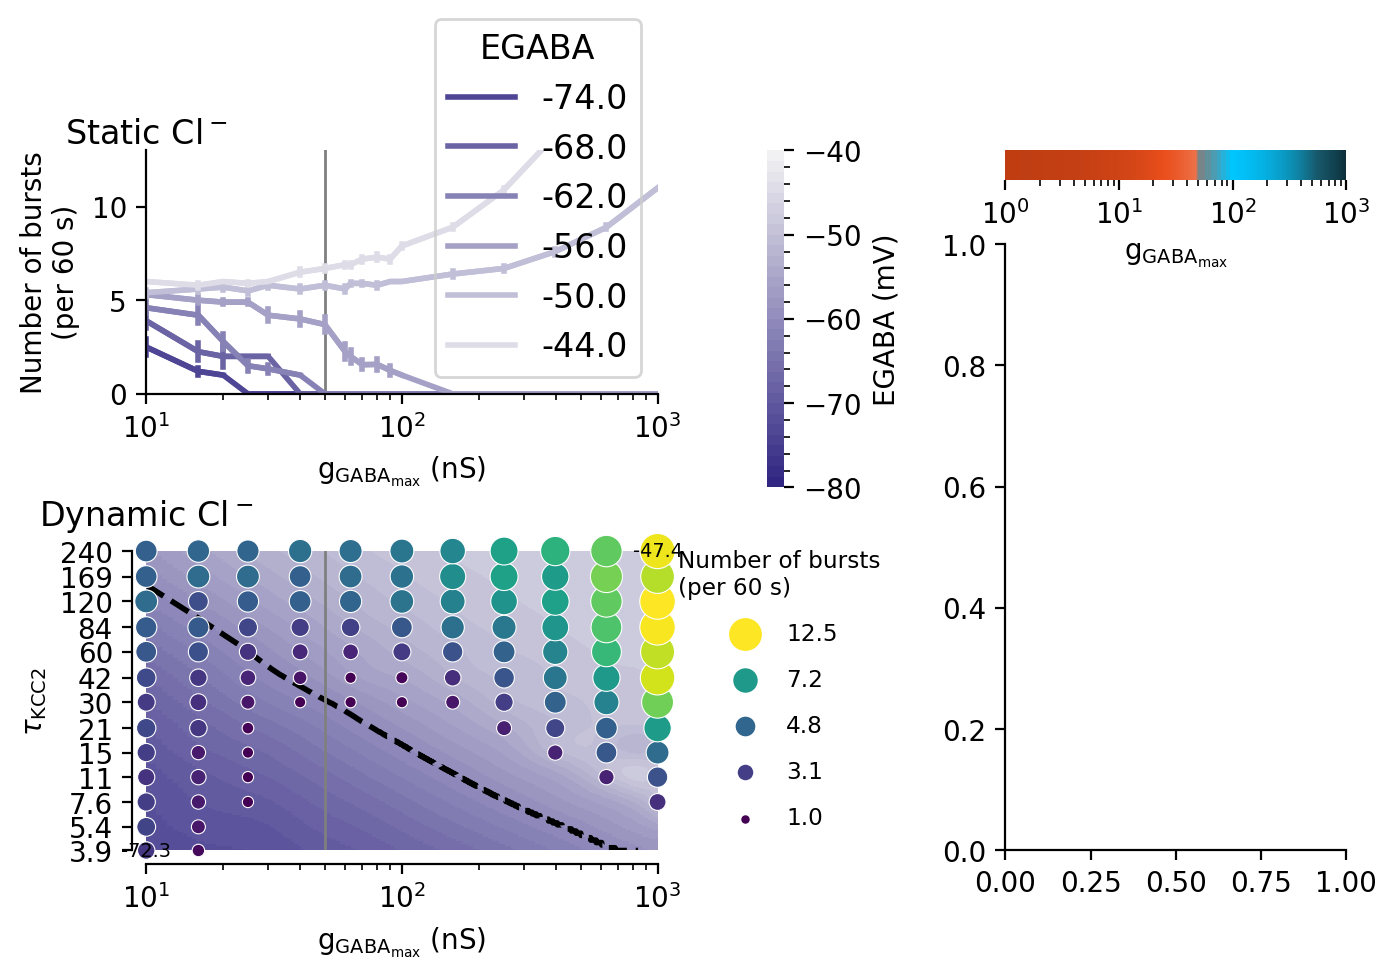

In [16]:
from scripts.lrdfigure_ggaba_e import Gve, mean_igaba, sum_igaba
from style.color import G_GABA_Norm

# add some more lower values for tau
tau_KCC2_list = list(TAU_KCC2_LIST)

ratio = tau_KCC2_list[1] / tau_KCC2_list[0]
tau_KCC2_list = [np.round(tau_KCC2_list[0] / ratio, 1)] + tau_KCC2_list
tau_KCC2_list = [np.round(tau_KCC2_list[0] / ratio, 1)] + tau_KCC2_list
tau_KCC2_list = [np.round(tau_KCC2_list[0] / ratio, 1)] + tau_KCC2_list
tau_KCC2_list = [np.round(tau_KCC2_list[0] / ratio, 1)] + tau_KCC2_list


gve = Gve(
    seeds=(
        None,
        1234,
        5678,
        1426987,
        86751,
        16928,
        98766,
        876125,
        127658,
        9876,
    ),
    gGABAsvEGABA=sorted(
        set(
            np.append(
                np.round(np.arange(0, 100.0001, 10), 0),
                np.geomspace(10, 1000, 11).round(0),
            )
        )
    ),
    gGABAs=np.geomspace(10, 1000, 11).round(0),
    tau_KCC2s=tau_KCC2_list,
)
gve.run()
gve.process()
gve.plot(egabas=5, i_metric="diagram")
if SAVE_FIGS:
    from style.figure import plot_save

    gve.save_figure(figs=gve.figs, **save_args)

LinregressResult(slope=0.2358594630765597, intercept=18.076419215147176, rvalue=0.4843821947426801, pvalue=6.765806051705923e-127, stderr=0.009191466687014867, intercept_stderr=0.5081612497984087)
LinregressResult(slope=0.005640726693045062, intercept=3.3805704394043694, rvalue=0.53021874245152, pvalue=4.798818216722885e-159, stderr=0.00019283280781048784, intercept_stderr=0.0874004358687039)


2024-02-23 21:34:41 [    INFO] saving to output/figure_5_gve_supp-2.jpg                                                   (plot_save::figure.py::64)


LinregressResult(slope=0.01815464403337192, intercept=3.487526529785792, rvalue=0.36847450587611624, pvalue=2.1617166530562244e-71, stderr=0.0009791978092449053, intercept_stderr=0.11141488344734743)


2024-02-23 21:34:41 [    INFO] Saved figures [1]                                                                          (plot_save::figure.py::80)
2024-02-23 21:34:41 [    INFO] saving to output/figure_5_gve_supp-2.svg                                                   (plot_save::figure.py::64)
2024-02-23 21:34:42 [    INFO] Saved figures [1]                                                                          (plot_save::figure.py::80)


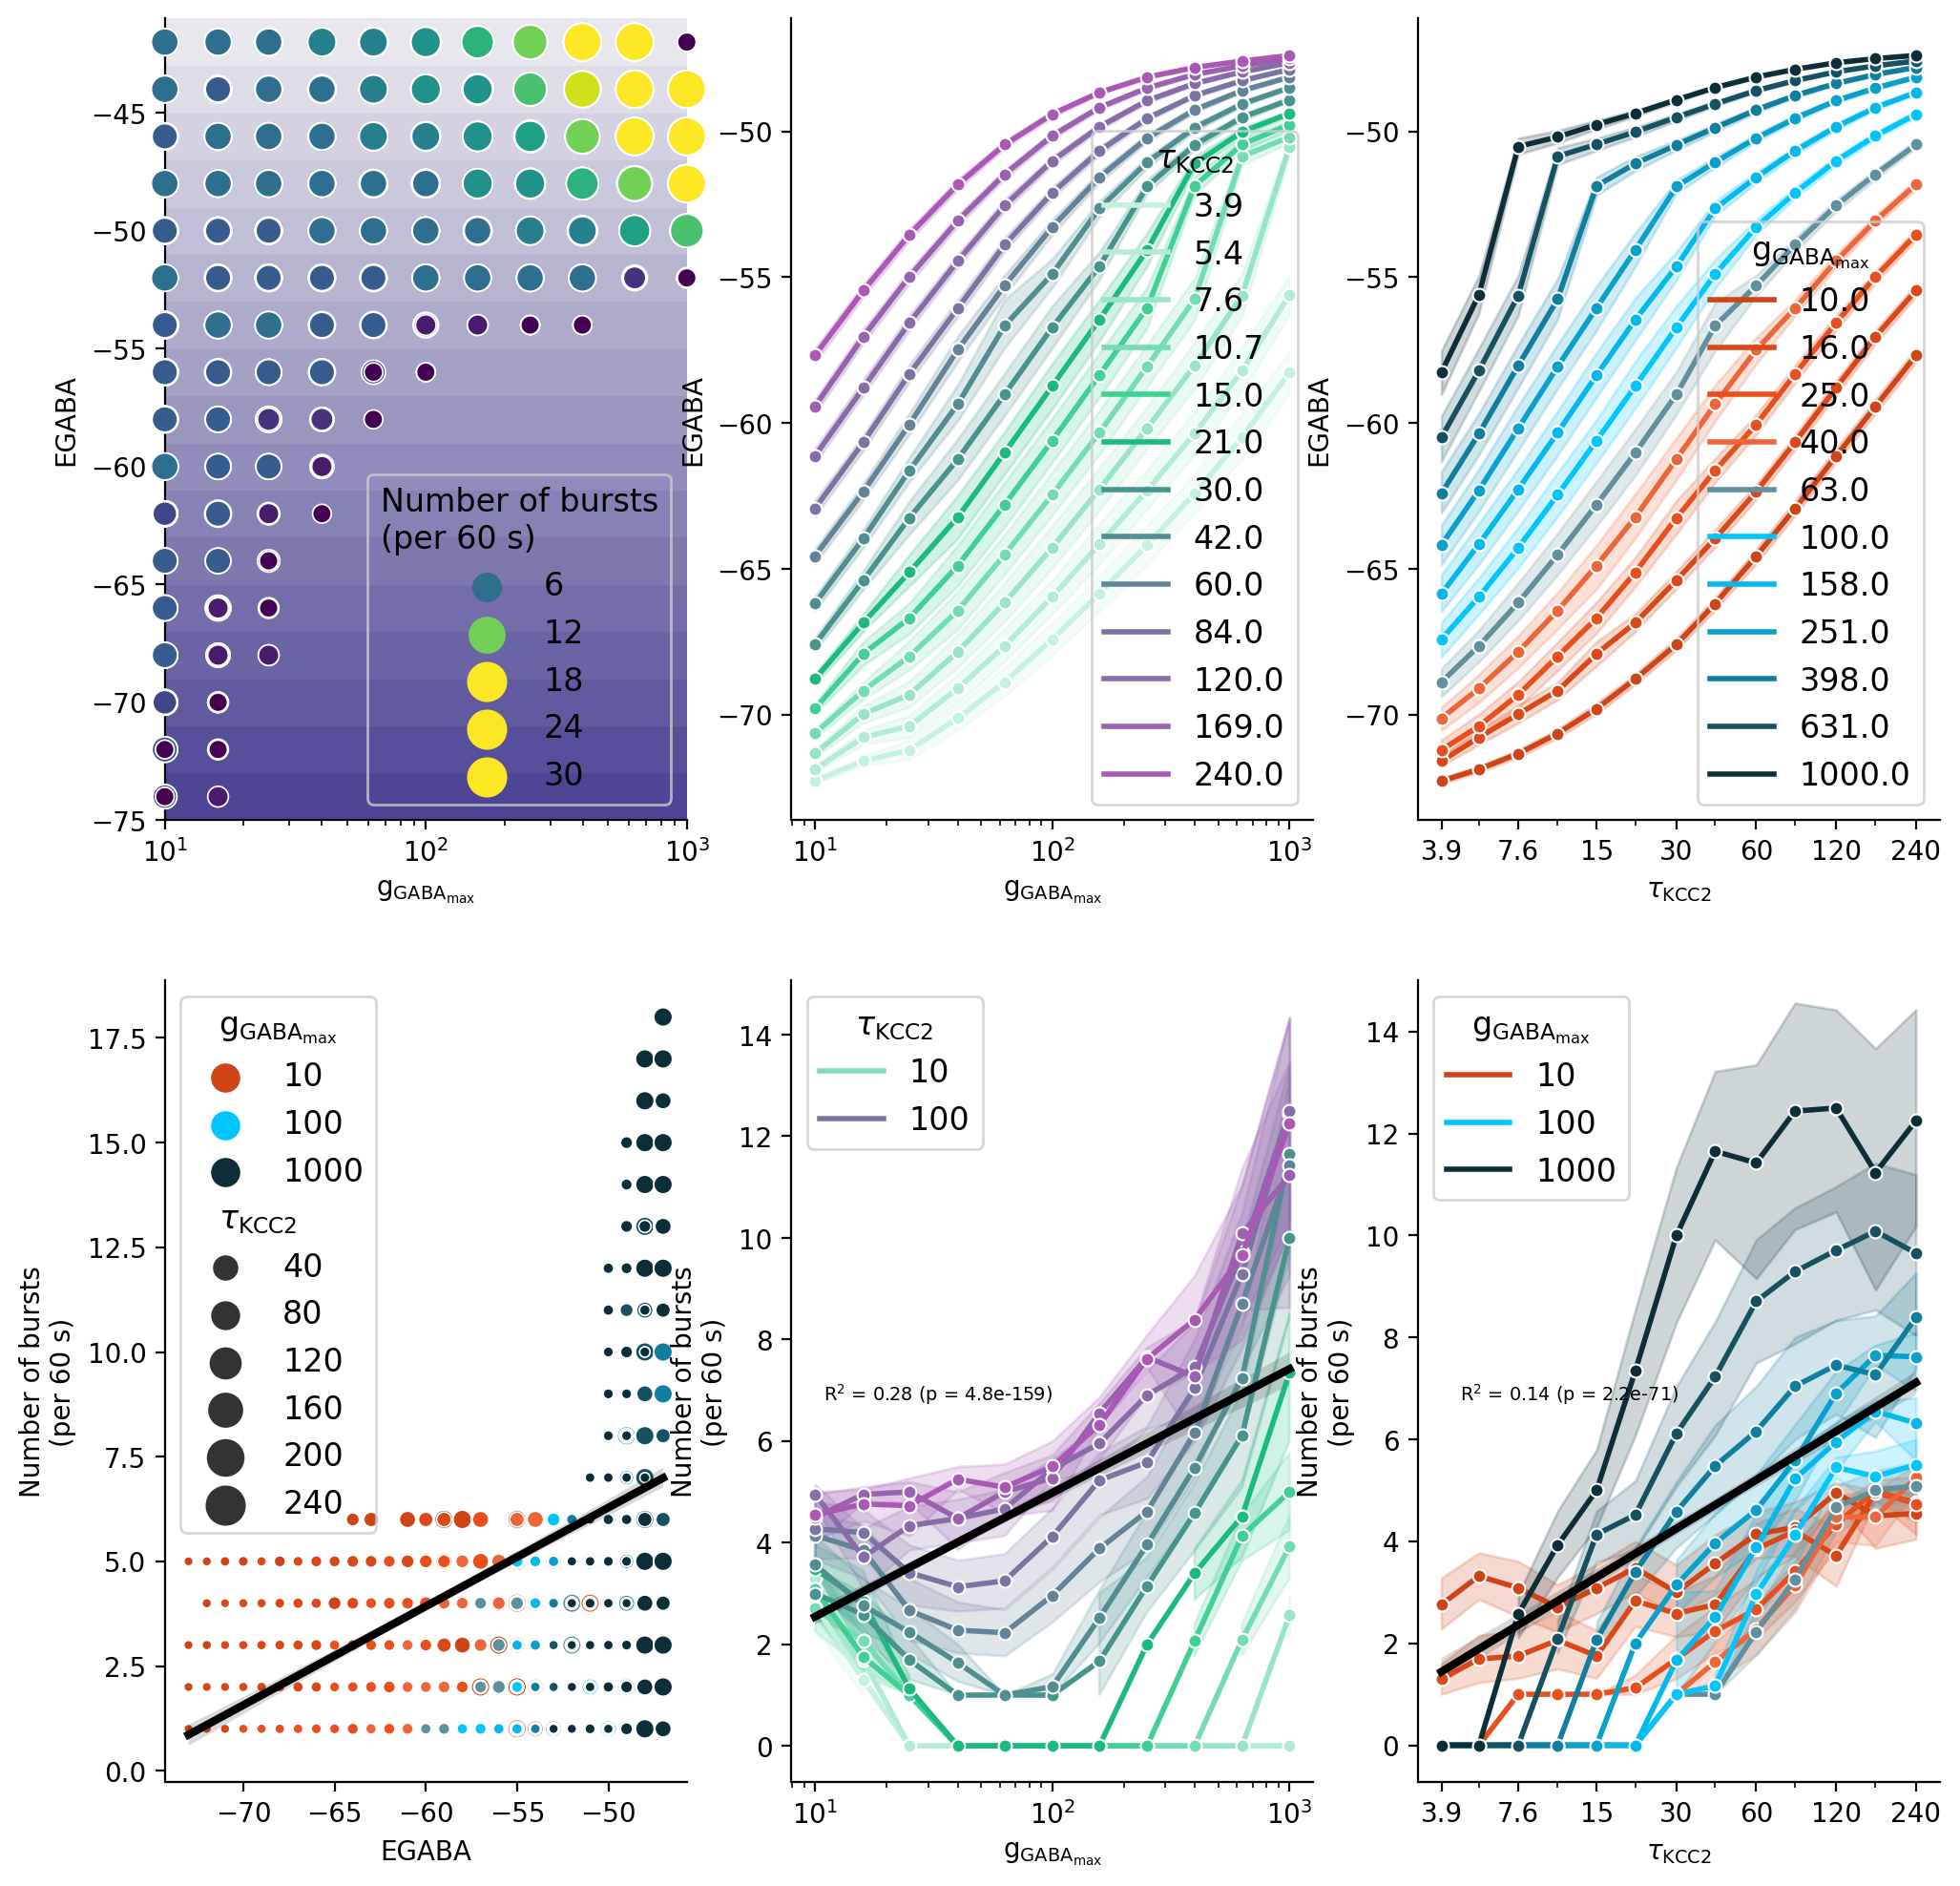

In [17]:
import itertools
import pandas as pd
import seaborn as sns

ggaba_ignore = []  # sorted(set(np.geomspace(60, 158, 7).round(0)) - {97})
if "$E_{GABA}$" in gve.df_g_tau_bursts:
    gve.df_g_tau_bursts["EGABA"] = gve.df_g_tau_bursts["$E_{GABA}$"]
df_sub_bursts = gve.df_g_tau_bursts[
    ~gve.df_g_tau_bursts[text.G_GABA].isin(ggaba_ignore)
]
df_sub_tau = gve.df_g_tau[~gve.df_g_tau[text.G_GABA].isin(ggaba_ignore)]

# fill in 0s for missing values
for gaba, tau in itertools.product(
    df_sub_tau[text.G_GABA].unique(), df_sub_tau[text.TAU_KCC2].unique()
):
    entry_exists = (
        df_sub_bursts[
            (df_sub_bursts[text.G_GABA] == gaba) & (df_sub_bursts[text.TAU_KCC2] == tau)
        ].shape[0]
        > 0
    )
    if not entry_exists:
        df_sub_bursts = pd.concat(
            [
                df_sub_bursts,
                pd.DataFrame(
                    {
                        text.G_GABA: gaba,
                        text.TAU_KCC2: tau,
                        gve.num_bursts_col: 0,
                    },
                    index=[0],
                ),
            ],
            ignore_index=True,
        )

fig, axs = plt.subplots(
    2,
    3,
    figsize=(12, 12),
    # sharey="row",
    # gridspec_kw={"width_ratios": [1, 1, 1]},
)
ax = axs[0, 0]

g_gabas = sorted(gve.df_g_E_bursts[text.G_GABA].unique())
egabas = sorted(gve.df_g_E_bursts["EGABA"].unique())
GG, EE = np.meshgrid(g_gabas, egabas)
ZZ = EE

ax.pcolor(GG, EE, ZZ, cmap=COLOR.EGABA_SM.get_cmap(), norm=COLOR.EGABA_SM.norm)
sns.scatterplot(
    data=gve.df_g_E_bursts[
        gve.df_g_E_bursts[text.G_GABA].isin(
            set(gve.df_g_tau_bursts[text.G_GABA].unique())
        )
    ],
    x=text.G_GABA,
    y="EGABA",
    size=gve.num_bursts_col,
    hue=gve.num_bursts_col,
    size_norm=(1, 15),
    hue_norm=(1, 15),
    ax=ax,
    palette="viridis",
    clip_on=False,
    zorder=10,
    # cmap=COLOR.EGABA_SM.get_cmap()
)

ax.set_xscale("log")
ax.set_xlim(10, 1000)

# g_gaba vs EGABA
ax_ggaba = axs[0, 1]

sns.lineplot(
    data=gve.df_g_tau,
    y="EGABA",
    x=text.G_GABA,
    hue=text.TAU_KCC2,
    palette=COLOR.TAU_SM.get_cmap(),
    hue_norm=COLOR.TAU_SM.norm,
    marker=".",
    ax=ax_ggaba,
    legend="full",
)
ax_ggaba.set_xscale("log")


# tau vs EGABA
ax_tau = axs[0, 2]

sns.lineplot(
    data=gve.df_g_tau,
    y="EGABA",
    x=text.TAU_KCC2,
    hue=text.G_GABA,
    palette=COLOR.G_GABA_SM.cmap,
    hue_norm=COLOR.G_GABA_SM.norm,
    marker=".",
    ax=ax_tau,
    legend="full",
)
taus = sorted(gve.df_g_tau[text.TAU_KCC2].unique())
ax_tau.set_xscale("log")
tau_labels = [f"{tau:.0f}" if int(tau) == float(tau) else f"{tau}" for tau in taus]
ax_tau.set_xticks(taus, labels=[], minor=True)
ax_tau.set_xticks(taus[::2], labels=tau_labels[::2])

# gve.plot_taukcc2(ax=axs[1,0], cax=axs[0, 1])


sns.scatterplot(
    data=df_sub_bursts,
    y=gve.num_bursts_col,
    x="EGABA",
    ax=axs[1, 0],
    marker=".",
    hue=text.G_GABA,
    palette=COLOR.G_GABA_SM.cmap,
    hue_norm=COLOR.G_GABA_SM.norm,
    size=text.TAU_KCC2,
)
from scipy import stats

reg_data = df_sub_bursts[["EGABA", gve.num_bursts_col]].dropna()
sns.regplot(
    data=reg_data,
    y=gve.num_bursts_col,
    x="EGABA",
    ax=axs[1, 0],
    scatter=False,
    color="k",
)
r = stats.linregress(reg_data["EGABA"], reg_data[gve.num_bursts_col])
print(r)
axs[1, 0].annotate(
    f"$R^2$ = {r.rvalue ** 2:.2f} (p = {r.pvalue:.2g})",
    xy=(0.5, 0.5),
    fontsize="xx-small",
    ha="right",
    va="top",
    color="k",
    # arrowprops=dict(arrowstyle='-|>',connectionstyle="arc3, rad=-0.1")
)
# only EGABA < -50
# reg_data = reg_data[reg_data["EGABA"] < -50]
# sns.regplot(
#     data=reg_data,
#     y=gve.num_bursts_col,
#     x="EGABA",
#     ax=axs[1, 0],
#     scatter=False,
#     color="k",
# )
# r = stats.linregress(reg_data["EGABA"], reg_data[gve.num_bursts_col])
# print(r)
# axs[1, 0].annotate(
#     f"$R^2$ = {r.rvalue ** 2:.2f} (p = {r.pvalue:.2g})",
#     xy=(0.5, 0.5),
#     xycoords="axes fraction",
#     fontsize="xx-small",
#     ha="right",
#     va="top",
#     # arrowprops=dict(arrowstyle='-|>',connectionstyle="arc3, rad=-0.1")
# )

sns.lineplot(
    data=df_sub_bursts,
    y=gve.num_bursts_col,
    x=text.G_GABA,
    hue=text.TAU_KCC2,
    palette=COLOR.TAU_SM.get_cmap(),
    hue_norm=COLOR.TAU_SM.norm,
    ax=axs[1, 1],
    marker=".",
    # multi="stack",
)

# regression
reg_data = df_sub_bursts[[text.G_GABA, gve.num_bursts_col]].dropna()
sns.regplot(
    data=reg_data,
    y=gve.num_bursts_col,
    x=text.G_GABA,
    ax=axs[1, 1],
    scatter=False,
    logx=True,
    color="k",
)
axs[1, 1].set_xscale("log")
r = stats.linregress(reg_data[text.G_GABA], reg_data[gve.num_bursts_col])
print(r)
axs[1, 1].annotate(
    f"$R^2$ = {r.rvalue ** 2:.2f} (p = {r.pvalue:.2g})",
    xy=(0.5, 0.5),
    xycoords="axes fraction",
    fontsize="xx-small",
    ha="right",
    va="top",
)

ax_tau_v_bursts = axs[1, 2]

sns.lineplot(
    data=df_sub_bursts,
    y=gve.num_bursts_col,
    x=text.TAU_KCC2,
    hue=text.G_GABA,
    ax=ax_tau_v_bursts,
    palette=COLOR.G_GABA_SM.cmap,
    hue_norm=COLOR.G_GABA_SM.norm,
    marker=".",
)
# reg
reg_data = df_sub_bursts[[text.TAU_KCC2, gve.num_bursts_col]].dropna()
sns.regplot(
    data=reg_data,
    y=gve.num_bursts_col,
    x=text.TAU_KCC2,
    ax=ax_tau_v_bursts,
    scatter=False,
    logx=True,
    color="k",
)
r = stats.linregress(reg_data[text.TAU_KCC2], reg_data[gve.num_bursts_col])
print(r)
ax_tau_v_bursts.annotate(
    f"$R^2$ = {r.rvalue ** 2:.2f} (p = {r.pvalue:.2g})",
    xy=(0.5, 0.5),
    xycoords="axes fraction",
    fontsize="xx-small",
    ha="right",
    va="top",
)

ax_tau_v_bursts.set_xscale("log")
ax_tau_v_bursts.set_xticks(taus, labels=[], minor=True)
ax_tau_v_bursts.set_xticks(taus[::2], labels=tau_labels[::2])
ax_tau_v_bursts.set_ylim(top=15)
from style.figure import plot_save

if SAVE_FIGS:
    plot_save(f"output/{gve.fig_name}_supp-2.jpg", figs=[fig], close=False)
    plot_save(f"output/{gve.fig_name}_supp-2.svg", figs=[fig], close=False)

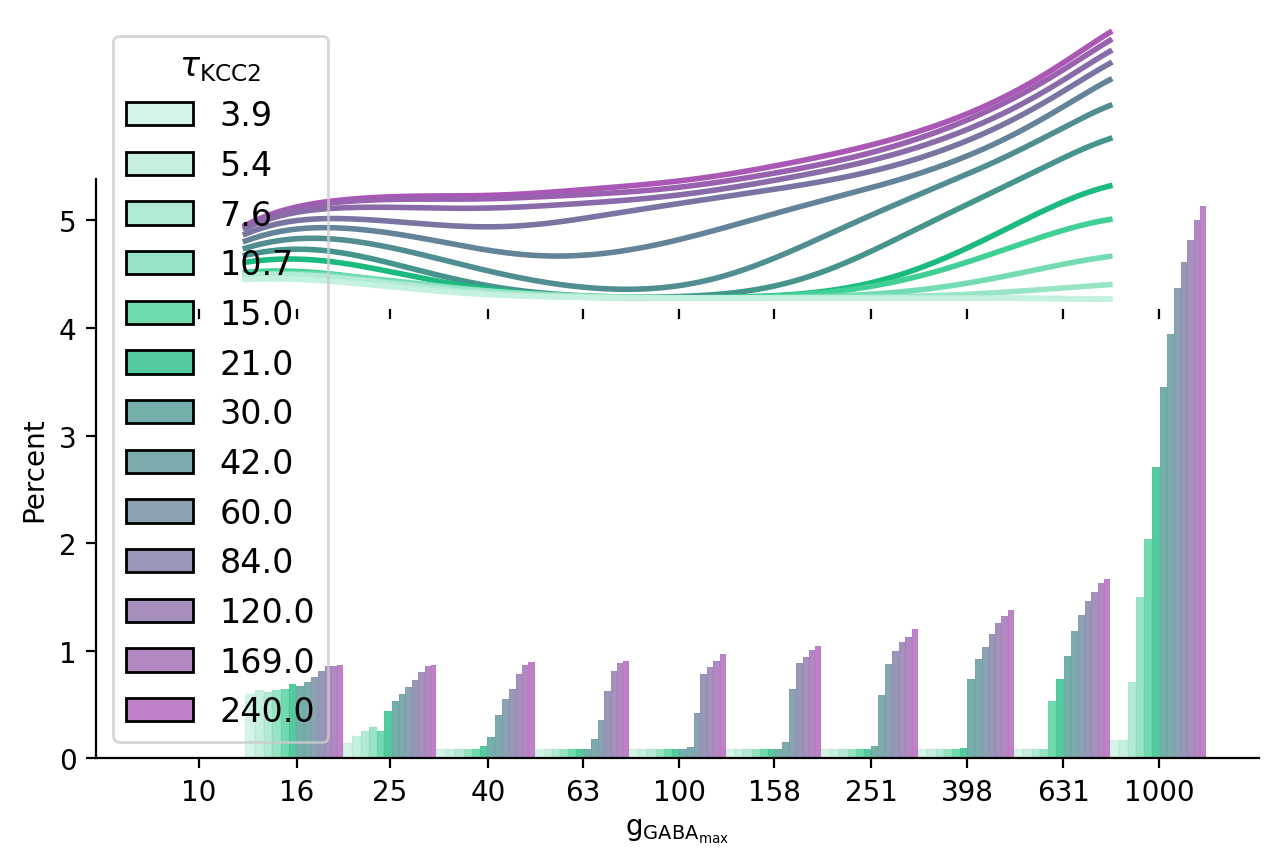

In [18]:
fig, axs = plt.subplots(2, gridspec_kw={"height_ratios": [0.5, 1]}, sharex=True)
fig.subplots_adjust(wspace=0, hspace=-0.3)

g_gaba_range = sorted(df_sub_bursts[text.G_GABA].unique())
g_gaba_ratio = (g_gaba_range[-2] / g_gaba_range[-1]).round(2)

ax_hist = axs[-1]
ax_kde = axs[0]
# ax_kde2 = axs[1]

common_kwargs = dict(
    data=df_sub_tau,
    x=text.G_GABA,
    hue=text.TAU_KCC2,
    palette=COLOR.TAU_SM.get_cmap(),
    hue_norm=COLOR.TAU_SM.norm,
    hue_order=sorted(df_sub_tau[text.TAU_KCC2].unique()),
)

sns.histplot(
    **common_kwargs,
    bins=[(g_gaba_range[0] * g_gaba_ratio).round(2)] + g_gaba_range,
    ax=ax_hist,
    multiple="dodge",
    stat="percent",
    legend=True,
)
sns.kdeplot(
    **common_kwargs,
    # common_norm=False,
    # common_grid=True,
    # fill=True,
    # alpha=0.2,
    # bw_adjust=0.7,
    ax=ax_kde,
    log_scale=True,
    legend=False,
    # cut=0.,
    clip=(1, 2.8),
)

# leg = ax_kde.get_legend()
# handles = leg.legend_handles
# labels = [float(t.get_text()) for t in leg.get_texts()]
# # format label to only have a decimal if it needs it
# labels = [f"{t:.0f}" if round(t) == t else f"{t}" for t in labels]

# ax_kde.legend(handles, labels, title=text.TAU_KCC2,
# labelcolor="linecolor",
# )

# sns.kdeplot(
#     **common_kwargs,
#     common_norm=False,
#     # common_grid=True,
#     fill=False,
#     alpha=0.5,
#     ax=ax_kde2,
#     log_scale=True,
#     legend=False,
#     cut=0.0,
# )
ax_hist.set_xscale("log")
ax_hist.set_xticks([], minor=True)
ax_hist.set_xticks(
    np.array(g_gaba_range) * 1.6 / 2, labels=[f"{g:.0f}" for g in g_gaba_range]
)
# ax_kde.set(xlabel="", xticks=[])
ax_kde.set(ylabel="", yticks=[], yticklabels=[])
# ax_kde.set_xticks([], minor=True)
sns.despine(ax=ax_kde, left=True, bottom=True)

## Supplementary: investigate how excitatory parameters affect the number of bursts.

Specifically, we vary:

1. $g_{AMPA_{\rm{max}}}$
2. $g_{NMDA_{\rm{max}}}$

And run static $Cl^-$ simulations at hyperpolarised (blue), close to $V_{rest}$ (purple), and depolarised (red) EGABA values.


In [ ]:
from scripts.lrdfigure_gampa import Params

exc_params = Params(
    gGABAs=[
        # 0,
        25,
        50,
        100,
        # 200,
    ],
    gAMPAs=np.round(np.arange(0, 20.0001, 5.0), 0),
    gNMDAs=[5.0, 7.5, 10.0],
    seeds=(None, 1013, 12987, 1234, 1837),
)
exc_params.run()
exc_params.process()
exc_params.plot(egabas=[-42, -56, -70])

if SAVE_FIGS:
    exc_params.save_figure(**save_args)

In [ ]:
exc_params.plot_rate_example()

# Playground


`None` keeps default values (see `core.sim.py`)


In [39]:
from core.sim import single_run
from widgets import new_playground_widget


def single_run_default_values(
    N=1000,
    duration=90,
    dt=0.01,
    Mg2_t0=1.0,
    zero_mag_wash_rate=5,
    benzo_onset_t=False,
    benzo_wash_rate=5,
    benzo_strength=1,
    benzo_off_t=False,
    # p=0.02,
    p_ee=0.02,
    p_ie=0.02,
    p_ei=0.04,
    p_ii=0.04,
    # w=1,
    w_ee=1,
    w_ei=1,
    w_ie=1,
    w_ii=1,
    U_0=0.01,
    tau_d=10,
    tau_f=0.5,
    g_AMPA_max=5,
    g_NMDA_max=5,
    g_GABA_max=50,
    E_Cl_0=-88.0,
    E_Cl_target=-88.0,
    E_Cl_end=-88.0,
    E_Cl_pop="None",
    length=7.5,
    dyn_cl=True,
    manual_cl=False,
    tau_KCC2_E=60,
    tau_KCC2_I=60,
    num_ecl_steps=1,
    nrn_idx_i=[0, 1],
    run_seed=11000,
):
    w = str(w)
    w_ee = str(w_ee)
    w_ei = str(w_ei)
    w_ie = str(w_ie)
    w_ii = str(w_ii)
    E_Cl_pop = None if E_Cl_pop == "None" else E_Cl_pop
    args = locals()
    return single_run(**args, __plot=True, __device_directory=f".cpp_{hash(args)}")


new_playground_widget(single_run_default_values)

interactive(children=(HBox(children=(Label(value='Simulation parameters', layout=Layout(width='200px'), style=…